<a href="https://colab.research.google.com/github/reglamarcador115/labo2025v/blob/main/src/rpart/102_FinalTrain_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbol elemental con libreria  rpart

## Introduccion

Este es el primer notebook/script de la materia Laboratorio de Implementacion I, se expone en la primera clase.
<br>Se utilizan Arboles de Decision, librería **rpart**,  el primer algoritmo, el más simple que utilizaremos en la materia pero que es el fundamento de los Ensembles de Arboles de Decision tales como  Random Forest y  Gradient Boosting of Decision Trees (XGBoost/LightGBM)
<br>La materia posee un dataset con 31 meses, en las primeras clases toda la cohorte, independiente de la modalidad elegida, utilizará **dataset_pequeno** que posee apenas un mes histórico 202107 y obviamente el mes donde se debe realizar la predicción 202109
<br>Este primer notebook/script **no** desarrolla todas las etapas necesarias para la generación de un buen modelo, apenas posee la parte final del pipeline/workflow.

### Limitaciones



Este primer y elemental notebook/script supone estas simplificaciónes:
* Solo se dispone del mes 202107 con el campo clase_ternaria completo, es el unico mes donde entrenar
* Se decidió previamente, de alguna forma, que la etapa de Final Training se hará sobre TODO el dataset de 202107
* Se obtuvieron previamente los hiperparámetros optimos de la libería **rpart** para este problema, mediante algun tipo de busqueda búsqueda.  Esta es la etapa que demandará decenas de horas para quienes opten por la *modalidad Analista Senior*
* No se realiza ningun tipo de feature engineering intra-mes
* Al no disponer de datos históricos no se realiza ningun tipo de feature engineering histórico
* No hay ningun analisis de la calidad de los campos, no se analiza si ocurrió alguna catástrofe ese mes y algun campo no se calculó correctamente
* Noy hay ningun tipo de análisis de Data Drifting entre los meses de 202107 y 202109
* Obedientemente se trabaja utlizando como clase el campo **clase_ternaria** sin ningun tipo de transformacion


<br> Obviamente, a lo largo de la materia se avanzará sobre todas las limitacinoes anteriores.

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/labo1"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/labo1" /content/buckets/b1




mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://docs.google.com/spreadsheets/d/1ernMbvIZDjOD_vpvYoY5Aw_69L7bPsa4/export?format=csv"
archivo_destino="/content/datasets/gridsearch_merge.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/gridsearch_merge.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


--2025-10-21 01:25:18--  https://docs.google.com/spreadsheets/d/1ernMbvIZDjOD_vpvYoY5Aw_69L7bPsa4/export?format=csv
Resolving docs.google.com (docs.google.com)... 173.194.210.139, 173.194.210.113, 173.194.210.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.210.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-9c-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/l5r75e3h631qeas1auvqupul0k/1761009915000/116215268542796760899/*/1ernMbvIZDjOD_vpvYoY5Aw_69L7bPsa4?format=csv [following]
--2025-10-21 01:25:18--  https://doc-00-9c-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/l5r75e3h631qeas1auvqupul0k/1761009915000/116215268542796760899/*/1ernMbvIZDjOD_vpvYoY5Aw_69L7bPsa4?format=csv
Resolving doc-00-9c-sheets.googleusercontent.com (doc-00-9c-sheets.googleusercontent.com)... 173.194.212.132, 2607:f8b0:400c:c11::84
Connecting to doc-00-9c-sheets.googleusercontent.com (doc-00-9c-sheets.goo

## Final Train y generacion de la prediccion

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [1]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657238,35.2,1454468,77.7,1252384,66.9
Vcells,1220261,9.4,8388608,64.0,1975128,15.1


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table**  **rpart** y  **rpart.plot**

In [2]:
# cargo las librerias que necesito
require("data.table")
require("rpart")
if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

Loading required package: data.table

Loading required package: rpart

Loading required package: rpart.plot

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rpart.plot’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: rpart.plot



Crear y moverse a la carpeta donde se va a trabajar

In [3]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "GRIDSEARCH_Merge"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

## Final Training

### Final Train Dataset

Es importante notar que para el entrenamiento final utilizo el mes de 202107 completo sin ningun tipo particion  train/test, aqui no hay random, aqui no hay semillas

In [38]:
# lectura del dataset
dataset <- fread("/content/datasets/gridsearch_merge.csv")
dataset[, cp := gsub(",", ".", cp)]
dataset[, cp := as.numeric(cp)]
dataset <- dataset[cp<=-0.1]
dtrain_final <- dataset[, !c("semilla", "Grupo"), with = FALSE] # defino donde voy a entrenar

summary(dtrain_final)

       cp             maxdepth         minsplit        minbucket     
 Min.   :-6.0000   Min.   : 2.000   Min.   :   5.0   Min.   :   1.0  
 1st Qu.:-1.0000   1st Qu.: 6.000   1st Qu.: 200.0   1st Qu.:  10.0  
 Median :-0.5000   Median : 8.000   Median : 550.0   Median :  33.0  
 Mean   :-0.9083   Mean   : 9.057   Mean   : 652.2   Mean   : 340.6  
 3rd Qu.:-0.5000   3rd Qu.:12.000   3rd Qu.: 800.0   3rd Qu.: 150.0  
 Max.   :-0.1000   Max.   :30.000   Max.   :8230.0   Max.   :8000.0  
 ganancia_test     
 Min.   :22640000  
 1st Qu.:43280000  
 Median :46540000  
 Mean   :46013373  
 3rd Qu.:49050000  
 Max.   :58870000  

### Hyperparameters

Árbol 1

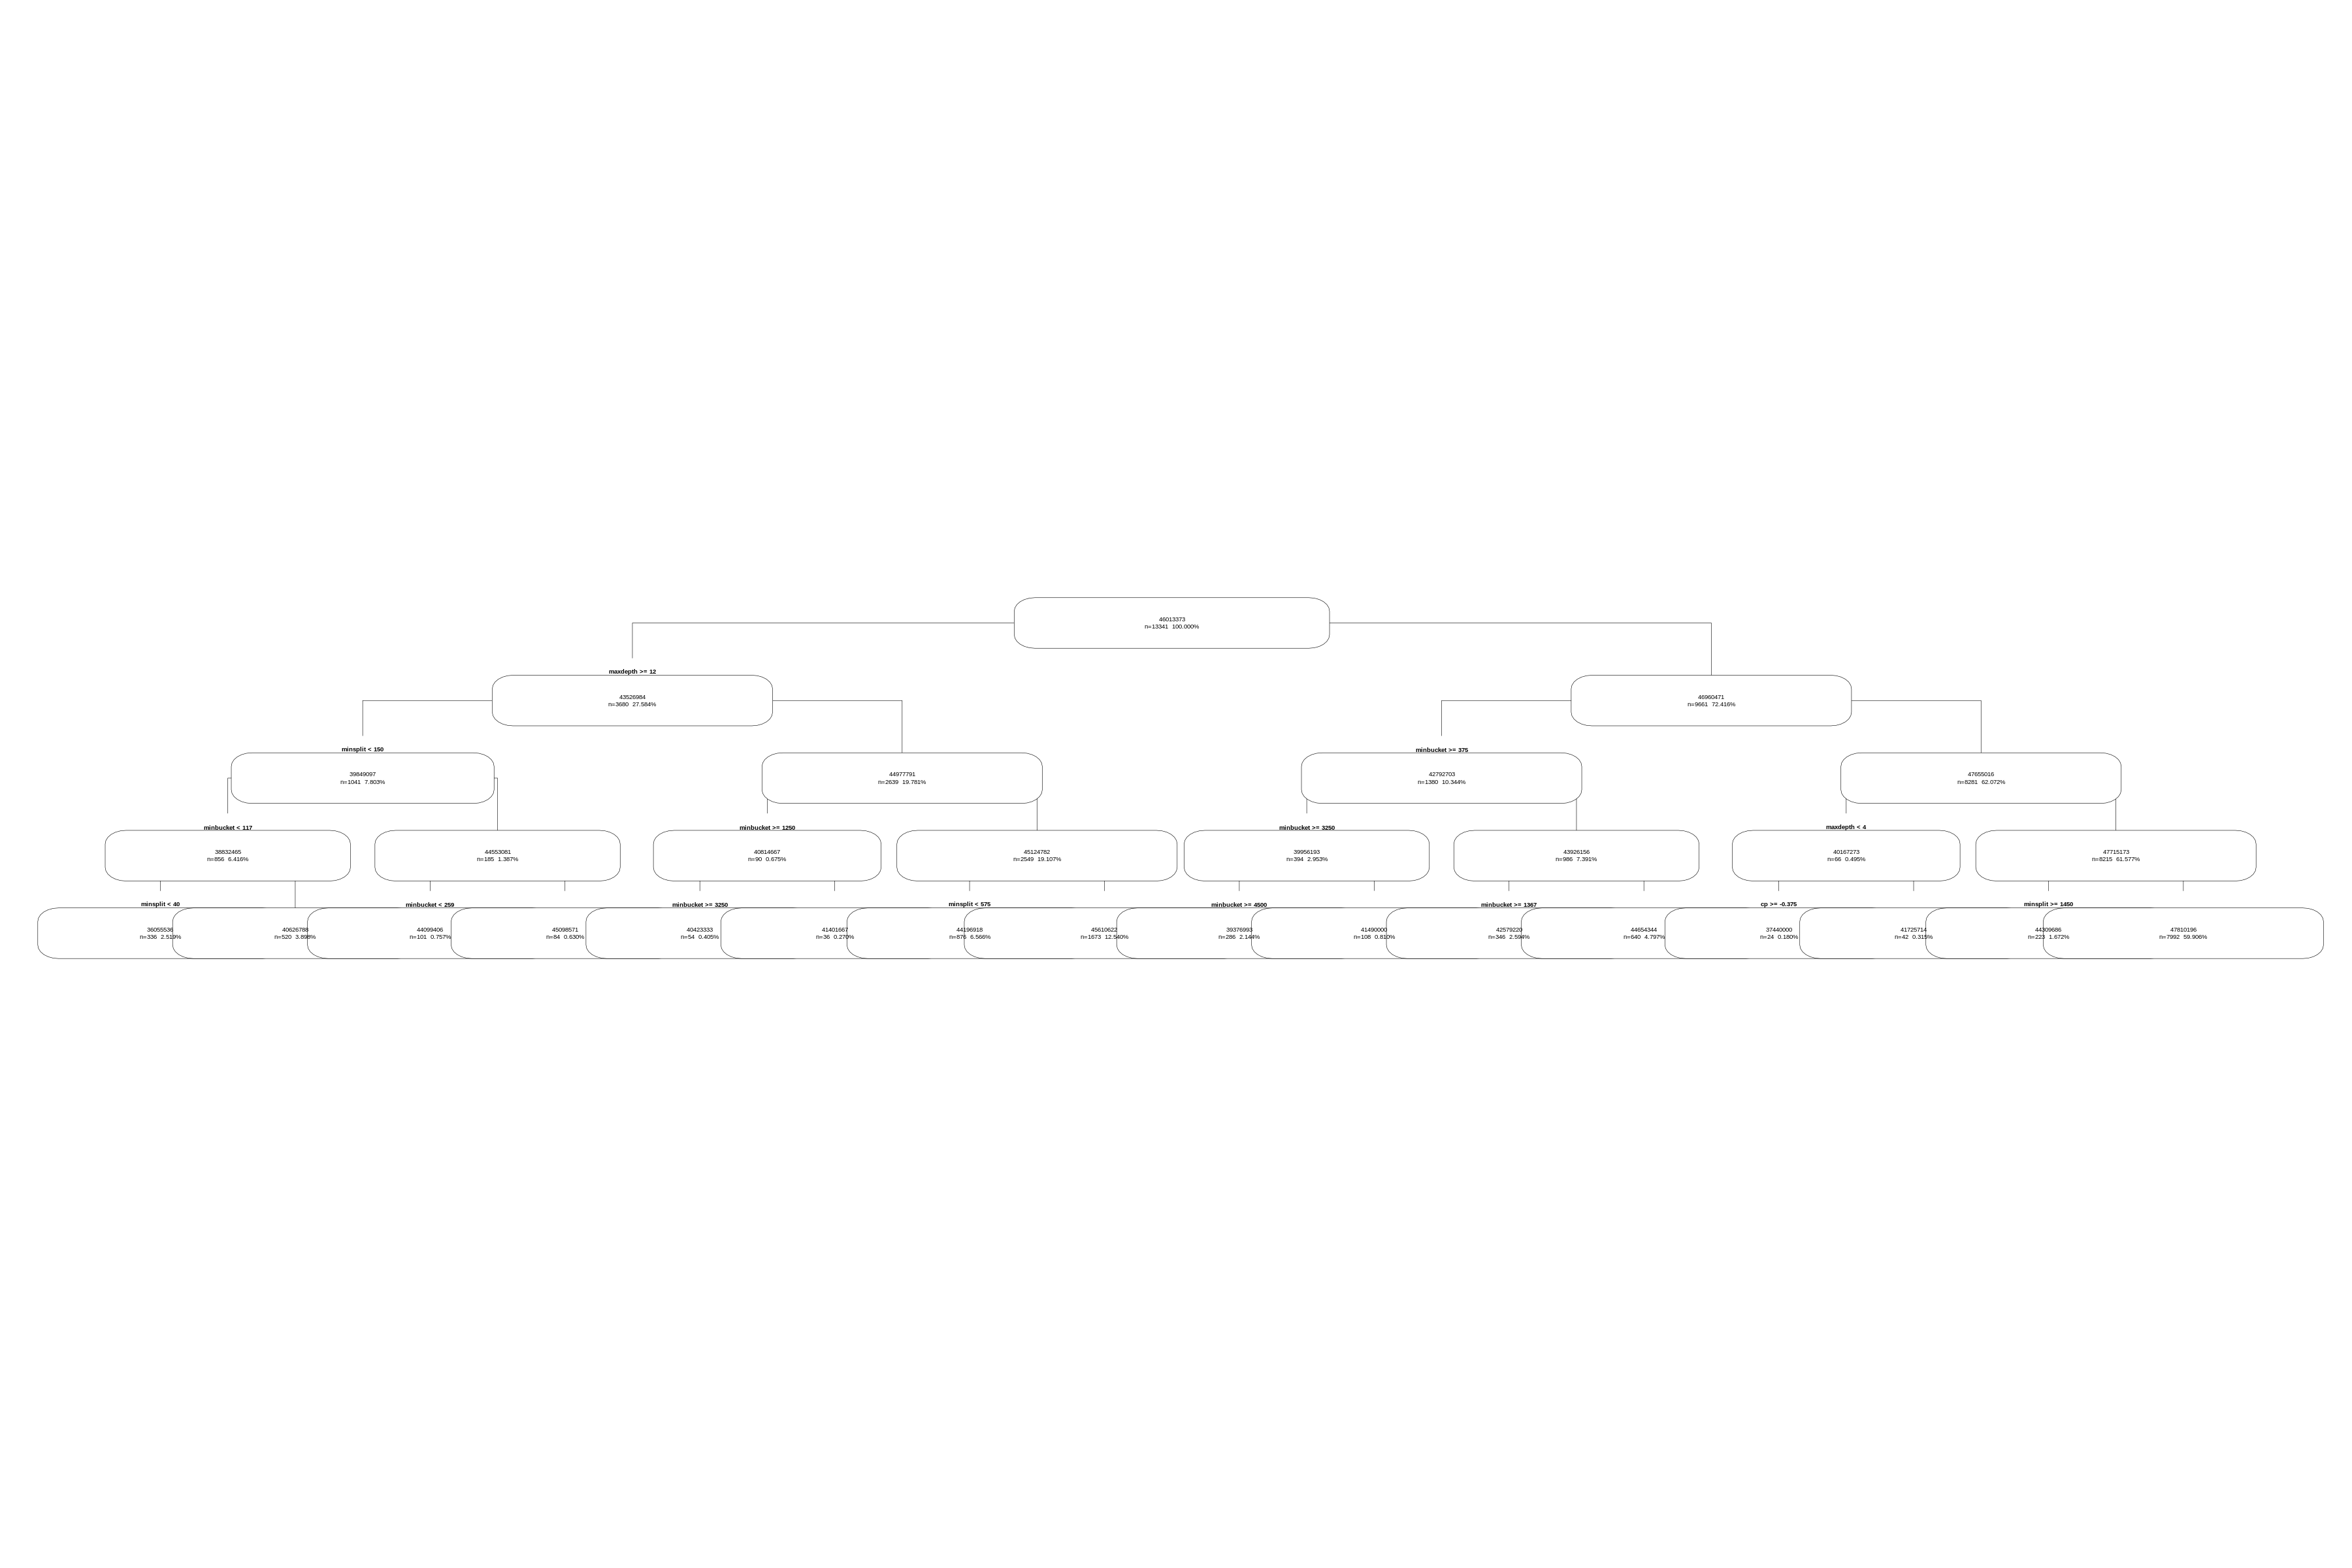

In [41]:
param_final <- list (
  "cp"= -1, # complejidad minima
  "minsplit"= 40, # minima cantidad de regs en un nodo para hacer el split
  "minbucket"= 20, # minima cantidad de regs en una hoja
  "maxdepth"= 4 # profundidad máxima del arbol
)

# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo_1 <- rpart(
    formula= "ganancia_test ~ .",
    data= dtrain_final, # los datos donde voy a entrenar
    xval= 0,
    control= param_final
)

# grafico el arbol
options(repr.plot.width=30, repr.plot.height=20 )

prp(modelo_1,
    extra= 101,
    digits= -5,
    branch= 1,
    type= 4,
    varlen= 0,
    faclen= 0,
    tweak= 2
)

Árbol 2

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


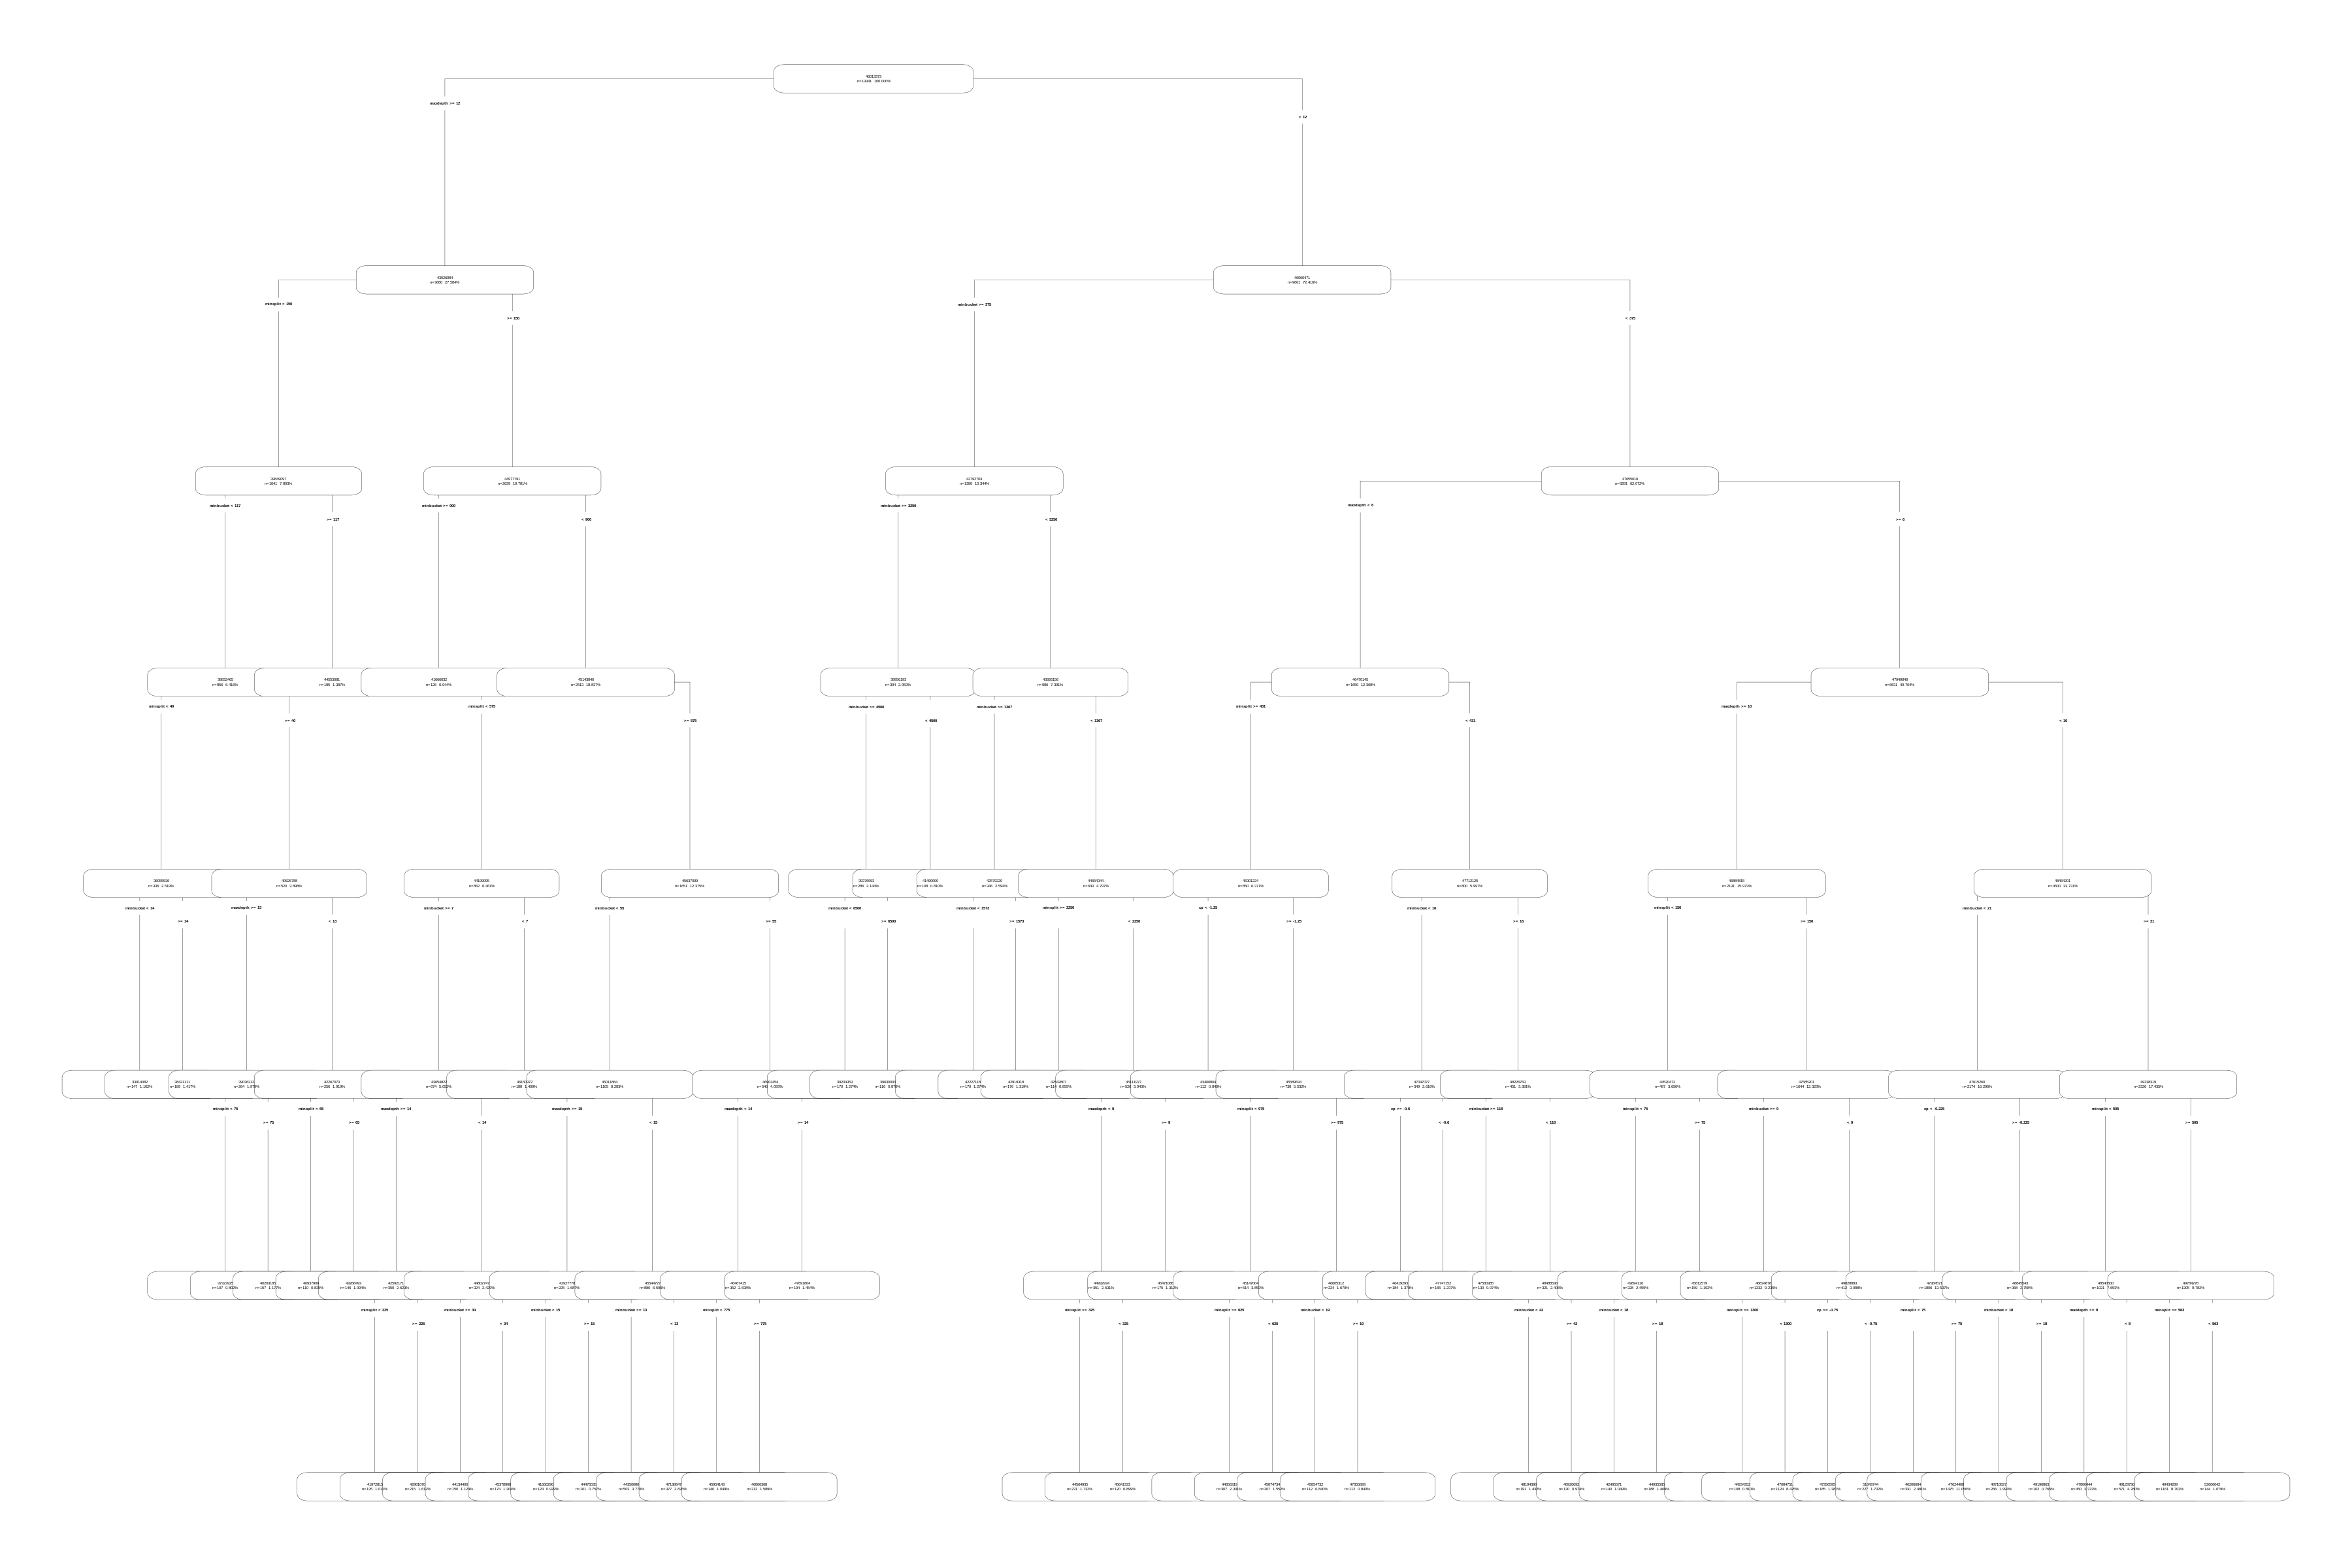

In [43]:
param_final <- list (
  "cp"= -1, # complejidad minima
  "minsplit"= 200, # minima cantidad de regs en un nodo para hacer el split
  "minbucket"= 100, # minima cantidad de regs en una hoja
  "maxdepth"= 7 # profundidad máxima del arbol
)

# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo_2 <- rpart(
    formula= "ganancia_test ~ .",
    data= dtrain_final, # los datos donde voy a entrenar
    xval= 0,
    control= param_final
)

# grafico el arbol
options(repr.plot.width=30, repr.plot.height=20 )

prp(modelo_2,
    extra= 101,
    digits= -5,
    branch= 1,
    type= 4,
    varlen= 0,
    faclen= 0,
    tweak= 2
)